In this notebook, I utilize the original ten fields in the dataset to generate variables that could accurately capture fraud behaviors. In total, I create 302 candidate variables. When creating these variables for each record i, I only look at the past records for the calculations. Next, I use a filter and wrapper method to identify the most important variables that can effectively capture fraudulent behaviors. This allows me to narrow down to the 28 most important variables.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
import re
start_time = pd.datetime.now()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  if __name__ == '__main__':


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV

In [ ]:
data = pd.read_csv('/content/drive/My Drive/5. USC/3. Spring 2020/DSO562 Fraud/Project/project03/card transactions_cleaned.csv', index_col=0)

In [ ]:
data.dtypes

Recnum                int64
Cardnum               int64
Date                 object
Merchnum             object
Merchdescription     object
Merchstate           object
Merchzip            float64
Transtype            object
Amount              float64
Fraud                 int64
dtype: object

In [ ]:
# adjusting data types
data['Date'] = pd.to_datetime(data['Date'])
data['Merchzip'] = data['Merchzip'].astype(int)
col = ["Cardnum", "Merchnum", "Merchstate", "Merchzip"]
for c in col:
    data[c] = data[c].astype(str)

## Feature Engineering

### Create five entity groups

I create the following five entity groups, which consist of different information for a credit card transaction:
- Cardnum: credit card number used in a transaction
- Merchnum: merchant number of the merchant
- Cardnum_Merchnum: combine Cardnum and Merchnum
- Cardnum_Merchzip: combine Cardnum and Merch zip
- Cardnum_Merchstate: combine Cardnum and Merch state

In [ ]:
data["Cardnum_Merchnum"] = data["Cardnum"] + "_" + data["Merchnum"]
data["Cardnum_Merchzip"] = data["Cardnum"] + "_" + data["Merchzip"]
data["Cardnum_Merchstate"] = data["Cardnum"] + "_" + data["Merchstate"]

In [ ]:
data

,Recnum,Cardnum,Date,Merchnum,Merchdescription,Merchstate,Merchzip,Transtype,Amount,Fraud,Cardnum_Merchnum,Cardnum_Merchzip,Cardnum_Merchstate
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0,5142190439_5509006296254,5142190439_38118,5142190439_TN
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803,P,31.42,0,5142183973_61003026333,5142183973_1803,5142183973_MA
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706,P,178.49,0,5142131721_4503082993600,5142131721_20706,5142131721_MD
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118,P,3.62,0,5142148452_5509006296254,5142148452_38118,5142148452_TN
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0,5142190439_5509006296254,5142190439_38118,5142190439_TN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96748,96749,5142276053,2010-12-31,3500000006160,BEST BUY 00001610,KY,41042,P,84.79,0,5142276053_3500000006160,5142276053_41042,5142276053_KY
96749,96750,5142225701,2010-12-31,8090710030950,MARKUS OFFICE SUPPLIES,OH,45248,P,118.75,0,5142225701_8090710030950,5142225701_45248,5142225701_OH
96750,96751,5142226486,2010-12-31,4503057341100,"TECH PAC, INC",OH,45150,P,363.56,0,5142226486_4503057341100,5142226486_45150,5142226486_OH
96751,96752,5142244619,2010-12-31,8834000695412,BUY.COM,CA,92656,P,2202.03,0,5142244619_8834000695412,5142244619_92656,5142244619_CA


### Week risk table variable

I create a risk table for each day of the week. The risk value of each day is calculated by the following formula:

$$ \text{# of fraud records of that day of week} \over \text{# of total records of that day of week} $$

Then, I utilize these values and a logistic smoothing function to create one variable called “risk_week” in which we set the value based on the day of the week of that record.

In [ ]:
Jan_Oct = data[data['Date'] < '2010-11-01'].copy()
Jan_Oct['weekday'] = Jan_Oct['Date'].apply(lambda x: x.weekday())

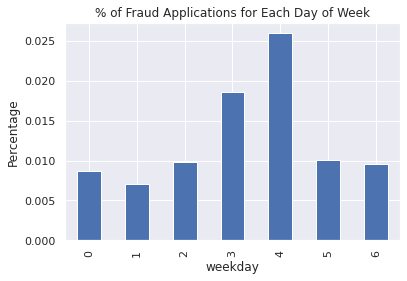

In [ ]:
sns.set()
Jan_Oct.groupby('weekday')['Fraud'].mean().plot(kind='bar')
plt.ylabel('Percentage')
plt.title('% of Fraud Applications for Each Day of Week')
plt.show()

In [ ]:
# calculate average of each group using smoothing function
c,nmid = 4,20
y_avg = Jan_Oct['Fraud'].mean()
y_weekday_avg = Jan_Oct.groupby('weekday')['Fraud'].mean()
num_instances_weekday = Jan_Oct.groupby('weekday').size()
y_weekday_smooth = y_avg + (y_weekday_avg-y_avg) / (1+np.exp(-(num_instances_weekday-nmid)/c))

# apply it to the entire dataset
data['risk_week'] = data['Date'].apply(lambda x: x.weekday()).map(y_weekday_smooth)

In [ ]:
data

,Recnum,Cardnum,Date,Merchnum,Merchdescription,Merchstate,Merchzip,Transtype,Amount,Fraud,Cardnum_Merchnum,Cardnum_Merchzip,Cardnum_Merchstate,risk_week
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0,5142190439_5509006296254,5142190439_38118,5142190439_TN,0.025994
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803,P,31.42,0,5142183973_61003026333,5142183973_1803,5142183973_MA,0.025994
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706,P,178.49,0,5142131721_4503082993600,5142131721_20706,5142131721_MD,0.025994
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118,P,3.62,0,5142148452_5509006296254,5142148452_38118,5142148452_TN,0.025994
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0,5142190439_5509006296254,5142190439_38118,5142190439_TN,0.025994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96748,96749,5142276053,2010-12-31,3500000006160,BEST BUY 00001610,KY,41042,P,84.79,0,5142276053_3500000006160,5142276053_41042,5142276053_KY,0.025994
96749,96750,5142225701,2010-12-31,8090710030950,MARKUS OFFICE SUPPLIES,OH,45248,P,118.75,0,5142225701_8090710030950,5142225701_45248,5142225701_OH,0.025994
96750,96751,5142226486,2010-12-31,4503057341100,"TECH PAC, INC",OH,45150,P,363.56,0,5142226486_4503057341100,5142226486_45150,5142226486_OH,0.025994
96751,96752,5142244619,2010-12-31,8834000695412,BUY.COM,CA,92656,P,2202.03,0,5142244619_8834000695412,5142244619_92656,5142244619_CA,0.025994


### Daysince, Frequency, Amount Variables

- **5 day-since variables**: Day-since variables are defined as the number of days since we last time saw the same entity. The smaller the number, the higher the possibility that it is a fraudulent transaction. For every value that appears the first time in the dataset, I set the value to 365. The logic to do so is that small values of the day since variables are riskier to be a fraudulent record. Therefore, I put a large number to differentiate them from records that are potentially fraudulent events.

$$ (\text{current date } - \text{the date of most recent transaction}) $$
$$ \text{with the same} $$
$$ (\text{Cardnum, Merchnum, Cardnum_Merchnum, Cardnum_Merchzip, Cardnum_Merchstate}) $$

- **30 Frequency variables**: The definition of frequency variables is how many records of the same value of an entity appeared in the past n days. The n here is the time window, and I used 0, 1, 3, 7, 14, and 30 days. If one value appears multiple times in a short time window, it is a sign of fraudulent behaviors. For example, if the same card number has 100 transactions over the past 3 days, that might be a sign of fraud activities.

$$ (\text{# of transactions}) $$
$$ \text{with the same} $$
$$ (\text{Cardnum, Merchnum, Cardnum_Merchnum, Cardnum_Merchzip, Cardnum_Merchstate}) $$
$$ \text{over the past} $$
$$ (\text{0, 1, 3, 7, 14, 30 days}) $$

- **240 Amount variables**: For each entity group, I created different amount variables, which are the amount spent by an entity over the past n days. The n here is the time window, and I used 0, 1, 3, 7, 14, and 30 days. We would like to know whether there is an unusual amount spent by a certain entity. Different types of amounts include average, maximum, median, total, actual/average, actual/maximum, actual/median, and actual/total amount. For example, if a card number has an extremely large maximum amount on a transaction over that past 3 days, it is highly possible that it is a fraudulent activity.

$$ (\text{mean, max, median, sum, actual/mean, actual/max, actual/median, actual/sum}) $$
$$ \text{Amount for the same} $$
$$ (\text{Cardnum, Merchnum, Cardnum_Merchnum, Cardnum_Merchzip, Cardnum_Merchstate}) $$
$$ \text{over the past} $$
$$ (\text{0, 1, 3, 7, 14, 30 days}) $$

In [ ]:
features = ['Cardnum','Merchnum','Cardnum_Merchnum','Cardnum_Merchzip','Cardnum_Merchstate']
timewindows = [0,1,3,7,14,30]

for feature in features:
  temp = data[['Recnum','Date', feature]]
  temp_selfjoin = pd.merge(temp, temp, left_on=feature, right_on=feature)
  temp_amount = data[['Recnum','Date', 'Amount', feature]]
  temp_amount_selfjoin = pd.merge(temp_amount, temp_amount, left_on=feature, right_on=feature)
  
  # daysince variables
  temp_filter = temp_selfjoin[temp_selfjoin['Recnum_x'] > temp_selfjoin['Recnum_y']]
  colname = feature + '_daysince'
  temp_final = temp_filter.groupby([feature, 'Recnum_x'])[['Date_x','Date_y']].last().reset_index()
  temp_final[colname] = (temp_final['Date_x']-temp_final['Date_y']) / np.timedelta64(1, "D") # converting timedelta64[ns] to numeric
  temp_final = temp_final.drop(columns=[feature,'Date_x','Date_y']).rename(columns={'Recnum_x':'Recnum'})
  data = data.merge(temp_final, on='Recnum', how='left')
  data[colname] = data[colname].fillna(365).astype(int)

  for timewindow in timewindows:
    # frequency variables
    temp_filter = temp_selfjoin[(temp_selfjoin['Recnum_x'] >= temp_selfjoin['Recnum_y'])&(temp_selfjoin['Date_x'] - temp_selfjoin['Date_y'] <= timedelta(days=timewindow))]
    colname = feature + '_frequency_' + str(timewindow)
    temp_final = temp_filter.groupby([feature, 'Recnum_x'])['Recnum_y'].count().reset_index().drop(columns=[feature]).rename(columns={'Recnum_x':'Recnum', 'Recnum_y':colname})
    data = data.merge(temp_final, on='Recnum', how='left')
    data[colname] = data[colname].fillna(0)

    # amount variables
    temp_filter = temp_amount_selfjoin[(temp_amount_selfjoin['Recnum_x'] >= temp_amount_selfjoin['Recnum_y'])&(temp_amount_selfjoin['Date_x'] - temp_amount_selfjoin['Date_y'] <= timedelta(days=timewindow))]
    temp_final = temp_filter.groupby([feature, 'Recnum_x'])['Amount_y'].agg(['mean', 'max', 'median', 'sum']).reset_index().drop(columns=[feature]).rename(columns={'Recnum_x':'Recnum'})
    data = data.merge(temp_final, on='Recnum', how='left')
    cols = ['mean','max','median','sum']
    for col in cols:
      data[col].fillna(1)
      data[feature+'_actualdiv'+col+'_'+str(timewindow)] = data['Amount'] / data[col]
      data.rename(columns={col:feature+'_'+col+'_'+str(timewindow)}, inplace=True)

In [ ]:
data

,Recnum,Cardnum,Date,Merchnum,Merchdescription,Merchstate,Merchzip,Transtype,Amount,Fraud,Cardnum_Merchnum,Cardnum_Merchzip,Cardnum_Merchstate,risk_week,Cardnum_daysince,Cardnum_frequency_0,Cardnum_mean_0,Cardnum_max_0,Cardnum_median_0,Cardnum_sum_0,Cardnum_actualdivmean_0,Cardnum_actualdivmax_0,Cardnum_actualdivmedian_0,Cardnum_actualdivsum_0,Cardnum_frequency_1,Cardnum_mean_1,Cardnum_max_1,Cardnum_median_1,Cardnum_sum_1,Cardnum_actualdivmean_1,Cardnum_actualdivmax_1,Cardnum_actualdivmedian_1,Cardnum_actualdivsum_1,Cardnum_frequency_3,Cardnum_mean_3,Cardnum_max_3,Cardnum_median_3,Cardnum_sum_3,Cardnum_actualdivmean_3,Cardnum_actualdivmax_3,...,Cardnum_Merchstate_actualdivmean_1,Cardnum_Merchstate_actualdivmax_1,Cardnum_Merchstate_actualdivmedian_1,Cardnum_Merchstate_actualdivsum_1,Cardnum_Merchstate_frequency_3,Cardnum_Merchstate_mean_3,Cardnum_Merchstate_max_3,Cardnum_Merchstate_median_3,Cardnum_Merchstate_sum_3,Cardnum_Merchstate_actualdivmean_3,Cardnum_Merchstate_actualdivmax_3,Cardnum_Merchstate_actualdivmedian_3,Cardnum_Merchstate_actualdivsum_3,Cardnum_Merchstate_frequency_7,Cardnum_Merchstate_mean_7,Cardnum_Merchstate_max_7,Cardnum_Merchstate_median_7,Cardnum_Merchstate_sum_7,Cardnum_Merchstate_actualdivmean_7,Cardnum_Merchstate_actualdivmax_7,Cardnum_Merchstate_actualdivmedian_7,Cardnum_Merchstate_actualdivsum_7,Cardnum_Merchstate_frequency_14,Cardnum_Merchstate_mean_14,Cardnum_Merchstate_max_14,Cardnum_Merchstate_median_14,Cardnum_Merchstate_sum_14,Cardnum_Merchstate_actualdivmean_14,Cardnum_Merchstate_actualdivmax_14,Cardnum_Merchstate_actualdivmedian_14,Cardnum_Merchstate_actualdivsum_14,Cardnum_Merchstate_frequency_30,Cardnum_Merchstate_mean_30,Cardnum_Merchstate_max_30,Cardnum_Merchstate_median_30,Cardnum_Merchstate_sum_30,Cardnum_Merchstate_actualdivmean_30,Cardnum_Merchstate_actualdivmax_30,Cardnum_Merchstate_actualdivmedian_30,Cardnum_Merchstate_actualdivsum_30
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0,5142190439_5509006296254,5142190439_38118,5142190439_TN,0.025994,365,1,3.620,3.62,3.620,3.62,1.00000,1.000000,1.00000,1.000000,1,3.620,3.62,3.620,3.62,1.000000,1.000000,1.00000,1.000000,1,3.620000,3.62,3.62,3.62,1.000000,1.000000,...,1.000000,1.0,1.000000,1.000000,1,3.620,3.62,3.620,3.62,1.000000,1.000000,1.000000,1.000000,1,3.620,3.62,3.620,3.62,1.000000,1.000000,1.000000,1.000000,1,3.620,3.62,3.620,3.62,1.000000,1.000000,1.000000,1.000000,1,3.620,3.62,3.620,3.62,1.000000,1.000000,1.000000,1.000000
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803,P,31.42,0,5142183973_61003026333,5142183973_1803,5142183973_MA,0.025994,365,1,31.420,31.42,31.420,31.42,1.00000,1.000000,1.00000,1.000000,1,31.420,31.42,31.420,31.42,1.000000,1.000000,1.00000,1.000000,1,31.420000,31.42,31.42,31.42,1.000000,1.000000,...,1.000000,1.0,1.000000,1.000000,1,31.420,31.42,31.420,31.42,1.000000,1.000000,1.000000,1.000000,1,31.420,31.42,31.420,31.42,1.000000,1.000000,1.000000,1.000000,1,31.420,31.42,31.420,31.42,1.000000,1.000000,1.000000,1.000000,1,31.420,31.42,31.420,31.42,1.000000,1.000000,1.000000,1.000000
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706,P,178.49,0,5142131721_4503082993600,5142131721_20706,5142131721_MD,0.025994,365,1,178.490,178.49,178.490,178.49,1.00000,1.000000,1.00000,1.000000,1,178.490,178.49,178.490,178.49,1.000000,1.000000,1.00000,1.000000,1,178.490000,178.49,178.49,178.49,1.000000,1.000000,...,1.000000,1.0,1.000000,1.000000,1,178.490,178.49,178.490,178.49,1.000000,1.000000,1.000000,1.000000,1,178.490,178.49,178.490,178.49,1.000000,1.000000,1.000000,1.000000,1,178.490,178.49,178.490,178.49,1.000000,1.000000,1.000000,1.000000,1,178.490,178.49,178.490,178.49,1.000000,1.000000,1.000000,1.000000
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118,P,3.62,0,5142148452_5509006296254,5142148452_38118,5142148452_TN,0.025994,365,1,3.620,3.62,3.620,3.62,1.00000,1.000000,1.00000,1.000000,1,3.620,3.62,3.620,3.62,1.000000,1.000000,1.00

### Velocity_change variables

After creating all the frequency and amount variables mentioned above, I look at whether the activities of the recent past are typical for an entity. For a given entity, these 24 variables indicate the ratio of its transaction activities recently to those in the past. If this value is extremely high, it would mean that the entity has been acting unusually compared to its past transaction records.

In [ ]:
for feature in ['Cardnum','Merchnum']:
  for timewindow in [7,14,30]:
    data[feature+'_frequencydivfrequency_'+'0_'+str(timewindow)] = data[feature+'_frequency_'+str(0)]/(data[feature+'_frequency_'+str(timewindow)]/timewindow)
    data[feature+'_frequencydivfrequency_'+'1_'+str(timewindow)] = data[feature+'_frequency_'+str(1)]/(data[feature+'_frequency_'+str(timewindow)]/timewindow)
    data[feature+'_sumdivsum_'+'0_'+str(timewindow)] = data[feature+'_sum_'+str(0)]/(data[feature+'_sum_'+str(timewindow)]/timewindow)
    data[feature+'_sumdivsum_'+'1_'+str(timewindow)] = data[feature+'_sum_'+str(1)]/(data[feature+'_sum_'+str(timewindow)]/timewindow)

In [ ]:
data

,Recnum,Cardnum,Date,Merchnum,Merchdescription,Merchstate,Merchzip,Transtype,Amount,Fraud,Cardnum_Merchnum,Cardnum_Merchzip,Cardnum_Merchstate,risk_week,Cardnum_daysince,Cardnum_frequency_0,Cardnum_mean_0,Cardnum_max_0,Cardnum_median_0,Cardnum_sum_0,Cardnum_actualdivmean_0,Cardnum_actualdivmax_0,Cardnum_actualdivmedian_0,Cardnum_actualdivsum_0,Cardnum_frequency_1,Cardnum_mean_1,Cardnum_max_1,Cardnum_median_1,Cardnum_sum_1,Cardnum_actualdivmean_1,Cardnum_actualdivmax_1,Cardnum_actualdivmedian_1,Cardnum_actualdivsum_1,Cardnum_frequency_3,Cardnum_mean_3,Cardnum_max_3,Cardnum_median_3,Cardnum_sum_3,Cardnum_actualdivmean_3,Cardnum_actualdivmax_3,...,Cardnum_Merchstate_max_14,Cardnum_Merchstate_median_14,Cardnum_Merchstate_sum_14,Cardnum_Merchstate_actualdivmean_14,Cardnum_Merchstate_actualdivmax_14,Cardnum_Merchstate_actualdivmedian_14,Cardnum_Merchstate_actualdivsum_14,Cardnum_Merchstate_frequency_30,Cardnum_Merchstate_mean_30,Cardnum_Merchstate_max_30,Cardnum_Merchstate_median_30,Cardnum_Merchstate_sum_30,Cardnum_Merchstate_actualdivmean_30,Cardnum_Merchstate_actualdivmax_30,Cardnum_Merchstate_actualdivmedian_30,Cardnum_Merchstate_actualdivsum_30,Cardnum_frequencydivfrequency_0_7,Cardnum_frequencydivfrequency_1_7,Cardnum_sumdivsum_0_7,Cardnum_sumdivsum_1_7,Cardnum_frequencydivfrequency_0_14,Cardnum_frequencydivfrequency_1_14,Cardnum_sumdivsum_0_14,Cardnum_sumdivsum_1_14,Cardnum_frequencydivfrequency_0_30,Cardnum_frequencydivfrequency_1_30,Cardnum_sumdivsum_0_30,Cardnum_sumdivsum_1_30,Merchnum_frequencydivfrequency_0_7,Merchnum_frequencydivfrequency_1_7,Merchnum_sumdivsum_0_7,Merchnum_sumdivsum_1_7,Merchnum_frequencydivfrequency_0_14,Merchnum_frequencydivfrequency_1_14,Merchnum_sumdivsum_0_14,Merchnum_sumdivsum_1_14,Merchnum_frequencydivfrequency_0_30,Merchnum_frequencydivfrequency_1_30,Merchnum_sumdivsum_0_30,Merchnum_sumdivsum_1_30
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0,5142190439_5509006296254,5142190439_38118,5142190439_TN,0.025994,365,1,3.620,3.62,3.620,3.62,1.00000,1.000000,1.00000,1.000000,1,3.620,3.62,3.620,3.62,1.000000,1.000000,1.00000,1.000000,1,3.620000,3.62,3.62,3.62,1.000000,1.000000,...,3.62,3.620,3.62,1.000000,1.000000,1.000000,1.000000,1,3.620,3.62,3.620,3.62,1.000000,1.000000,1.000000,1.000000,7.000000,7.000000,7.000000,7.000000,14.000000,14.000000,14.000000,14.000000,30.000000,30.000000,30.000000,30.000000,7.000000,7.000000,7.000000,7.000000,14.000000,14.000000,14.000000,14.000000,30.000000,30.000000,30.000000,30.000000
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803,P,31.42,0,5142183973_61003026333,5142183973_1803,5142183973_MA,0.025994,365,1,31.420,31.42,31.420,31.42,1.00000,1.000000,1.00000,1.000000,1,31.420,31.42,31.420,31.42,1.000000,1.000000,1.00000,1.000000,1,31.420000,31.42,31.42,31.42,1.000000,1.000000,...,31.42,31.420,31.42,1.000000,1.000000,1.000000,1.000000,1,31.420,31.42,31.420,31.42,1.000000,1.000000,1.000000,1.000000,7.000000,7.000000,7.000000,7.000000,14.000000,14.000000,14.000000,14.000000,30.000000,30.000000,30.000000,30.000000,7.000000,7.000000,7.000000,7.000000,14.000000,14.000000,14.000000,14.000000,30.000000,30.000000,30.000000,30.000000
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706,P,178.49,0,5142131721_4503082993600,5142131721_20706,5142131721_MD,0.025994,365,1,178.490,178.49,178.490,178.49,1.00000,1.000000,1.00000,1.000000,1,178.490,178.49,178.490,178.49,1.000000,1.000000,1.00000,1.000000,1,178.490000,178.49,178.49,178.49,1.000000,1.000000,...,178.49,178.490,178.49,1.000000,1.000000,1.000000,1.000000,1,178.490,178.49,178.490,178.49,1.000000,1.000000,1.000000,1.000000,7.000000,7.000000,7.000000,7.000000,14.000000,14.000000,14.000000,14.000000,30.000000,30.000000,30.000000,30.000000,7.000000,7.000000,7.000000,7.000000,14.000000,14.000000,14.000000,14.000000,30.000000,30.000000,30.000000,30.000000
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118,P,3.62,0,5142148452_5509006296254,51421

### Benford Law variables

The Benford variable is a metric based on Benford's Law. According to Benford's Law, for a natural measurement, the first non-zero digits follow a certain distribution that 1 and 2 appear around 47.7%. It will be considered unusual if a measurement does not follow this distribution. And in our case, if the “Amount” values of a certain card number or a certain merchant number are far away from this distribution, that means it is not natural and might be more possible to be fraudulent.

First, I use regular expressions to exclude all records that are associated with FEDEX. The reason behind this is that most of the Amount values of FEDEX records are around 3.6, which gives us a huge number of records that start with 3 for FEDEX merchant and will result in high unusualness based on Benford’s law. However, we know that FEDEX is not a fraud merchant, so we exclude all FEDEX records to avoid taking the FEDEX merchant as a fraud merchant.

In [ ]:
# removing Merchdescription containing 'Fedex', 'Federal Express', or 'Fed Ex' (e.g. USGPO SOD-FED EX)
temp_benford = data.Merchdescription.str.lower().str.extract(r'(fedex|federal express|fed ex)').isnull()[0]
data_benford = data[temp_benford].reset_index(drop=True)

Then, I categorize every record to either low (denoted with 1) or high (denoted with 0). Then, I create a new column called benfordclass, assigning the value to 1 if the first non-zero digit of the Amount of that record is either “1” or “2,” and the value to 0 if the first non-zero digit of the Amount of that record is “3” to “9.”

In [ ]:
data_benford[data_benford.Amount<=0.1]

,Recnum,Cardnum,Date,Merchnum,Merchdescription,Merchstate,Merchzip,Transtype,Amount,Fraud,Cardnum_Merchnum,Cardnum_Merchzip,Cardnum_Merchstate,risk_week,Cardnum_daysince,Cardnum_frequency_0,Cardnum_mean_0,Cardnum_max_0,Cardnum_median_0,Cardnum_sum_0,Cardnum_actualdivmean_0,Cardnum_actualdivmax_0,Cardnum_actualdivmedian_0,Cardnum_actualdivsum_0,Cardnum_frequency_1,Cardnum_mean_1,Cardnum_max_1,Cardnum_median_1,Cardnum_sum_1,Cardnum_actualdivmean_1,Cardnum_actualdivmax_1,Cardnum_actualdivmedian_1,Cardnum_actualdivsum_1,Cardnum_frequency_3,Cardnum_mean_3,Cardnum_max_3,Cardnum_median_3,Cardnum_sum_3,Cardnum_actualdivmean_3,Cardnum_actualdivmax_3,...,Cardnum_Merchstate_max_14,Cardnum_Merchstate_median_14,Cardnum_Merchstate_sum_14,Cardnum_Merchstate_actualdivmean_14,Cardnum_Merchstate_actualdivmax_14,Cardnum_Merchstate_actualdivmedian_14,Cardnum_Merchstate_actualdivsum_14,Cardnum_Merchstate_frequency_30,Cardnum_Merchstate_mean_30,Cardnum_Merchstate_max_30,Cardnum_Merchstate_median_30,Cardnum_Merchstate_sum_30,Cardnum_Merchstate_actualdivmean_30,Cardnum_Merchstate_actualdivmax_30,Cardnum_Merchstate_actualdivmedian_30,Cardnum_Merchstate_actualdivsum_30,Cardnum_frequencydivfrequency_0_7,Cardnum_frequencydivfrequency_1_7,Cardnum_sumdivsum_0_7,Cardnum_sumdivsum_1_7,Cardnum_frequencydivfrequency_0_14,Cardnum_frequencydivfrequency_1_14,Cardnum_sumdivsum_0_14,Cardnum_sumdivsum_1_14,Cardnum_frequencydivfrequency_0_30,Cardnum_frequencydivfrequency_1_30,Cardnum_sumdivsum_0_30,Cardnum_sumdivsum_1_30,Merchnum_frequencydivfrequency_0_7,Merchnum_frequencydivfrequency_1_7,Merchnum_sumdivsum_0_7,Merchnum_sumdivsum_1_7,Merchnum_frequencydivfrequency_0_14,Merchnum_frequencydivfrequency_1_14,Merchnum_sumdivsum_0_14,Merchnum_sumdivsum_1_14,Merchnum_frequencydivfrequency_0_30,Merchnum_frequencydivfrequency_1_30,Merchnum_sumdivsum_0_30,Merchnum_sumdivsum_1_30
48263,56125,5142129955,2010-07-25,991906628334,ALAMO FLAGS CO.,VA,22044,P,0.01,0,5142129955_991906628334,5142129955_22044,5142129955_VA,0.009630,5,1,0.010,0.01,0.010,0.01,1.000000,1.000000,1.000000,1.000000,1,0.0100,0.01,0.010,0.01,1.000000,1.000000,1.000000,1.000000,1,0.0100,0.01,0.010,0.01,1.000000,1.000000,...,0.01,0.010,0.01,1.000000,1.000000,1.000000,1.000000,1,0.010000,0.01,0.01,0.01,1.000000,1.000000,1.000000,1.000000,2.333333,2.333333,0.000275,0.000275,4.666667,4.666667,0.000550,0.000550,10.000000,10.000000,0.001179,0.001179,2.333333,2.333333,0.000275,0.000275,4.666667,4.666667,0.000550,0.000550,10.000000,10.000000,0.001179,0.001179
49764,57856,5142129787,2010-07-30,9108347680000,STAPLES NATIONAL #471,NJ,7606,P,0.02,0,5142129787_9108347680000,5142129787_7606,5142129787_NJ,0.025994,0,2,223.545,447.07,223.545,447.09,0.000089,0.000045,0.000089,0.000045,2,223.5450,447.07,223.545,447.09,0.000089,0.000045,0.000089,0.000045,4,155.9925,447.07,88.440,623.97,0.000128,0.000045,...,447.07,223.545,447.09,0.000089,0.000045,0.000089,0.000045,5,562.970000,2134.73,152.12,2814.85,0.000036,0.000009,0.000131,0.000007,3.500000,3.500000,5.015674,5.015674,5.600000,5.600000,9.595236,9.595236,5.000000,5.000000,3.441545,3.441545,3.500000,3.500000,4.867307,4.867307,4.000000,4.000000,5.537453,5.537453,3.529412,3.529412,4.111777,4.111777
67053,78388,5142236687,2010-09-28,9108233080006,STAPLES #990,CA,90640,P,0.01,0,5142236687_9108233080006,5142236687_90640,5142236687_CA,0.007127,0,3,238.020,706.19,7.860,714.06,0.000042,0.000014,0.001272,0.000014,4,180.9625,706.19,8.825,723.85,0.000055,0.000014,0.001133,0.000014,4,180.9625,706.19,8.825,723.85,0.000055,0.000014,...,0.01,0.010,0.01,1.000000,1.000000,1.000000,1.000000,1,0.010000,0.01,0.01,0.01,1.000000,1.000000,1.000000,1.000000,5.250000,7.000000,6.905326,7.000000,10.500000,14.000000,13.810651,14.000000,10.000000,13.333333,11.922527,12.085989,4.200000,4.200000,3.280118,3.280118,8.400000,8.400000,6.560237,6.560237,5.625000,5.625000,0.987395,0.987395
79506,91180,5142239369,2010-12-06,89200648125,JOHN WILEY & SON SOMERSET,NJ,8875,P,0.01,0,5142239369_89200648125,5142239369_8875,5

In [ ]:
data_benford['Amount_firstdigit'] = data_benford.Amount.apply(lambda x: int(str(x)[3]) if x<0.1 else (int(str(x)[2]) if x<1 else int(str(x)[:1])))
data_benford['benfordclass'] = data_benford['Amount_firstdigit'].apply(lambda x: 'low' if x<=2 else 'high')

I group by Cardnum and Merchnum and sum the values of benfordclass column mentioned above by looking at the records in the past only. I also group by Cardnum and Merchnum and count the number of records for each group.

In [ ]:
data_benford['benfordclass_cumcount_Cardnum'] = data_benford.groupby(['Cardnum','benfordclass']).cumcount()+1
data_benford['benfordclass_cumcount_Merchnum'] = data_benford.groupby(['Merchnum','benfordclass']).cumcount()+1
data_benford['cumcount_Cardnum'] = data_benford.groupby(['Cardnum']).cumcount()+1
data_benford['cumcount_Merchnum'] = data_benford.groupby(['Merchnum']).cumcount()+1

According to Benford’s law, the ratio of nhigh/nlow is about 1.096, so I create a measurement 'rate' which should be close to 1 if it follows Benford’s law. Since the rate could be unusual in both directions, I also calculate 1/R to capture the unusualness. Here, I also use the logistic smoothing function since we cannot fully trust that measurement if the number of records for a group is very small.

In [ ]:
Ustar = {'Cardnum':[], 'Merchnum':[]}

for col in ['Cardnum','Merchnum']:
  for i in range(0,data_benford.shape[0]):
    num = data_benford['cumcount_'+col][i]
    if data_benford['benfordclass'][i] == 'high':
      high = data_benford['benfordclass_cumcount_'+col][i]
      low = num-high
    else:
      low = data_benford['benfordclass_cumcount_'+col][i]
      high = num-low
    if low==0:
        low=1
    if high==0:
        high=1
    rate = 1.096*low/high
    unusual = max(rate, 1/rate)
    temp = (num-15)/3
    unusual_star = 1+(unusual-1)/(1+np.exp(-temp))
    Ustar[col].append(unusual_star)

In [ ]:
data_benford['Ustar_Cardnum'] = Ustar['Cardnum']
data_benford['Ustar_Merchnum'] = Ustar['Merchnum']
vlookup = data_benford[['Recnum','Ustar_Cardnum','Ustar_Merchnum']]
data = data.merge(vlookup, on='Recnum', how='left')
data['Ustar_Cardnum'] = data['Ustar_Cardnum'].fillna(1)
data['Ustar_Merchnum'] = data['Ustar_Merchnum'].fillna(1)

In [ ]:
data

,Recnum,Cardnum,Date,Merchnum,Merchdescription,Merchstate,Merchzip,Transtype,Amount,Fraud,Cardnum_Merchnum,Cardnum_Merchzip,Cardnum_Merchstate,risk_week,Cardnum_daysince,Cardnum_frequency_0,Cardnum_mean_0,Cardnum_max_0,Cardnum_median_0,Cardnum_sum_0,Cardnum_actualdivmean_0,Cardnum_actualdivmax_0,Cardnum_actualdivmedian_0,Cardnum_actualdivsum_0,Cardnum_frequency_1,Cardnum_mean_1,Cardnum_max_1,Cardnum_median_1,Cardnum_sum_1,Cardnum_actualdivmean_1,Cardnum_actualdivmax_1,Cardnum_actualdivmedian_1,Cardnum_actualdivsum_1,Cardnum_frequency_3,Cardnum_mean_3,Cardnum_max_3,Cardnum_median_3,Cardnum_sum_3,Cardnum_actualdivmean_3,Cardnum_actualdivmax_3,...,Cardnum_Merchstate_sum_14,Cardnum_Merchstate_actualdivmean_14,Cardnum_Merchstate_actualdivmax_14,Cardnum_Merchstate_actualdivmedian_14,Cardnum_Merchstate_actualdivsum_14,Cardnum_Merchstate_frequency_30,Cardnum_Merchstate_mean_30,Cardnum_Merchstate_max_30,Cardnum_Merchstate_median_30,Cardnum_Merchstate_sum_30,Cardnum_Merchstate_actualdivmean_30,Cardnum_Merchstate_actualdivmax_30,Cardnum_Merchstate_actualdivmedian_30,Cardnum_Merchstate_actualdivsum_30,Cardnum_frequencydivfrequency_0_7,Cardnum_frequencydivfrequency_1_7,Cardnum_sumdivsum_0_7,Cardnum_sumdivsum_1_7,Cardnum_frequencydivfrequency_0_14,Cardnum_frequencydivfrequency_1_14,Cardnum_sumdivsum_0_14,Cardnum_sumdivsum_1_14,Cardnum_frequencydivfrequency_0_30,Cardnum_frequencydivfrequency_1_30,Cardnum_sumdivsum_0_30,Cardnum_sumdivsum_1_30,Merchnum_frequencydivfrequency_0_7,Merchnum_frequencydivfrequency_1_7,Merchnum_sumdivsum_0_7,Merchnum_sumdivsum_1_7,Merchnum_frequencydivfrequency_0_14,Merchnum_frequencydivfrequency_1_14,Merchnum_sumdivsum_0_14,Merchnum_sumdivsum_1_14,Merchnum_frequencydivfrequency_0_30,Merchnum_frequencydivfrequency_1_30,Merchnum_sumdivsum_0_30,Merchnum_sumdivsum_1_30,Ustar_Cardnum,Ustar_Merchnum
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0,5142190439_5509006296254,5142190439_38118,5142190439_TN,0.025994,365,1,3.620,3.62,3.620,3.62,1.00000,1.000000,1.00000,1.000000,1,3.620,3.62,3.620,3.62,1.000000,1.000000,1.00000,1.000000,1,3.620000,3.62,3.62,3.62,1.000000,1.000000,...,3.62,1.000000,1.000000,1.000000,1.000000,1,3.620,3.62,3.620,3.62,1.000000,1.000000,1.000000,1.000000,7.000000,7.000000,7.000000,7.000000,14.000000,14.000000,14.000000,14.000000,30.000000,30.000000,30.000000,30.000000,7.000000,7.000000,7.000000,7.000000,14.000000,14.000000,14.000000,14.000000,30.000000,30.000000,30.000000,30.000000,1.000000,1.000000
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803,P,31.42,0,5142183973_61003026333,5142183973_1803,5142183973_MA,0.025994,365,1,31.420,31.42,31.420,31.42,1.00000,1.000000,1.00000,1.000000,1,31.420,31.42,31.420,31.42,1.000000,1.000000,1.00000,1.000000,1,31.420000,31.42,31.42,31.42,1.000000,1.000000,...,31.42,1.000000,1.000000,1.000000,1.000000,1,31.420,31.42,31.420,31.42,1.000000,1.000000,1.000000,1.000000,7.000000,7.000000,7.000000,7.000000,14.000000,14.000000,14.000000,14.000000,30.000000,30.000000,30.000000,30.000000,7.000000,7.000000,7.000000,7.000000,14.000000,14.000000,14.000000,14.000000,30.000000,30.000000,30.000000,30.000000,1.000894,1.000894
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706,P,178.49,0,5142131721_4503082993600,5142131721_20706,5142131721_MD,0.025994,365,1,178.490,178.49,178.490,178.49,1.00000,1.000000,1.00000,1.000000,1,178.490,178.49,178.490,178.49,1.000000,1.000000,1.00000,1.000000,1,178.490000,178.49,178.49,178.49,1.000000,1.000000,...,178.49,1.000000,1.000000,1.000000,1.000000,1,178.490,178.49,178.490,178.49,1.000000,1.000000,1.000000,1.000000,7.000000,7.000000,7.000000,7.000000,14.000000,14.000000,14.000000,14.000000,30.000000,30.000000,30.000000,30.000000,7.000000,7.000000,7.000000,7.000000,14.000000,14.000000,14.000000,14.000000,30.000000,30.000000,30.000000,30.000000,1.000894,1.000894
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118,P,3.62,0,5142148452_5509006296254,5142148452_38118

## Feature Selection

I first split the data into training (records from January-October) and test (records from November-December) and only use training data for the feature selection. I also leave out the first few weeks in January, since some variables are not all fully formed by then.

In [ ]:
data_train = data[(data.Date>'2010-01-14')&(data.Date<'2010-11-01')].reset_index(drop=True)
data_test = data[(data.Date>='2010-11-01')].reset_index(drop=True)

Then I Z-scale all the variables prior to the feature selection.

In [ ]:
scale = StandardScaler().fit_transform(data_train.iloc[:,13:])
data_scaled = pd.DataFrame(scale, columns=data_train.columns[13:])
data_scaled['Fraud'] = data_train['Fraud']

### Filter

For each variable, I calculate the univariate KS score, a maximum difference of the cumulative goods and bads, to measure the importance.

In [ ]:
goods = data_scaled[data_scaled.Fraud==0]
bads = data_scaled[data_scaled.Fraud==1]

In [ ]:
ksfdr = pd.DataFrame(columns=['ks','fdr'], index=range(0,len(data_scaled.columns[:-1])))

In [ ]:
i = 0
for column in data_scaled.columns[:-1]:
  ksfdr['ks'][i] = stats.ks_2samp(goods[column],bads[column])[0]
  i = i+1

Then, I calculate the fraud detection rate, the number of frauds caught in the top 3% of the population when it is sorted by each variable.

In [ ]:
topRows = int(round(len(data_scaled)*0.03))
numbads = len(bads)
j = 0
for column in data_scaled.columns[:-1]:
  FDR1 = data_scaled[[column,'Fraud']].sort_values(column,ascending=False).head(topRows)['Fraud'].sum()/numbads
  FDR2 = data_scaled[[column,'Fraud']].sort_values(column,ascending=True).head(topRows)['Fraud'].sum()/numbads
  FDRate = np.maximum(FDR1,FDR2)
  ksfdr.loc[j, 'fdr'] = FDRate
  j = j +1

After calculating the ranks for the two scores, I use the average of them to select 80 candidate variables.

In [ ]:
ksfdr['fields'] = data_scaled.columns[:-1]
ksfdr['rank_ks'] = ksfdr['ks'].rank(ascending = True)
ksfdr['rank_fdr'] = ksfdr['fdr'].rank(ascending = True)
ksfdr['average_rank'] = (ksfdr['rank_ks'] + ksfdr['rank_fdr']) / 2
ksfdr.sort_values(['average_rank','fdr','ks'], ascending=False, inplace=True)
ksfdr = ksfdr[['fields','ks','fdr','rank_ks','rank_fdr','average_rank']]

In [ ]:
ksfdr.head(83)

,fields,ks,fdr,rank_ks,rank_fdr,average_rank
143,Cardnum_Merchnum_sum_7,0.68265,0.634793,302.0,301.0,301.50
198,Cardnum_Merchzip_sum_7,0.680588,0.633641,301.0,300.0,300.50
189,Cardnum_Merchzip_sum_3,0.673583,0.637097,297.0,302.0,299.50
244,Cardnum_Merchstate_sum_3,0.674561,0.632488,299.0,298.5,298.75
152,Cardnum_Merchnum_sum_14,0.675351,0.631336,300.0,297.0,298.50
...,...,...,...,...,...,...
88,Merchnum_sum_7,0.553749,0.345622,213.0,241.0,227.00
39,Cardnum_mean_14,0.531209,0.404378,202.0,248.5,225.25
170,Cardnum_Merchzip_median_0,0.564852,0.299539,230.0,219.5,224.75
225,Cardnum_Merchstate_median_0,0.56109,0.302995,223.0,225.0,224.00


In [ ]:
data_scaled = data_scaled[ksfdr.head(80)['fields'].tolist()+['Fraud']]

### Wrapper

Now I perform the backward step selection using the feature ranking method with recursive feature elimination and cross-validated selection in the sklearn. I use logistic regression as a base model and accuracy for the metrics. The general process for the backward step selection can be explained by the following:
- Build a simple model (in this case, logistic regression) using all 80  variables
- Then, build 80 separate models each removing one variable, and select the best model
- Next, build 79 separate models each removing one variable, and select the best model
- Continue the procedure until the model degradation is below an acceptable amount

In [ ]:
X = data_scaled.drop(columns='Fraud')
y = data_scaled['Fraud']
model = LogisticRegression(max_iter=2000)
rfecv = RFECV(estimator=model, step=1, cv=2, verbose=0, n_jobs=-1, scoring='accuracy')
rfecv.fit(X, y)

RFECV(cv=2,
      estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                   fit_intercept=True, intercept_scaling=1,
                                   l1_ratio=None, max_iter=2000,
                                   multi_class='auto', n_jobs=None,
                                   penalty='l2', random_state=None,
                                   solver='lbfgs', tol=0.0001, verbose=0,
                                   warm_start=False),
      min_features_to_select=1, n_jobs=-1, scoring='accuracy', step=1,
      verbose=0)

In [ ]:
table = pd.DataFrame(zip(X.columns, rfecv.ranking_), columns=['vars','score']).sort_values('score')
table

,vars,score
0,Cardnum_Merchnum_sum_7,1
25,Cardnum_Merchnum_max_3,1
28,Cardnum_Merchzip_max_3,1
30,Merchnum_sum_1,1
35,Cardnum_Merchzip_max_1,1
...,...,...
41,Cardnum_Merchstate_max_0,49
29,Cardnum_Merchzip_max_7,50
79,Cardnum_mean_14,51
55,Cardnum_mean_3,52


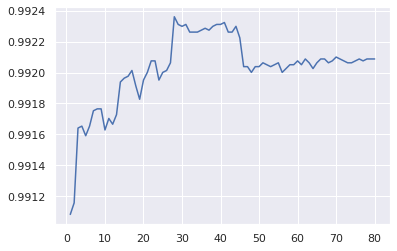

In [ ]:
rfecvgrid = pd.Series(rfecv.grid_scores_)
plt.plot(range(1,len(rfecvgrid)+1), rfecvgrid)
plt.show()

This plot shows the number of features in the model along with the cross-validated test score.

In [ ]:
print(f'The final number of selected features with cross-validation is {rfecv.n_features_}')

The final number of selected features with cross-validation are 28


In [ ]:
data_final = data[['Recnum','Date','Fraud']+table.vars[:rfecv.n_features_].tolist()]

In [ ]:
data_final

,Recnum,Date,Fraud,Cardnum_Merchnum_sum_7,Cardnum_Merchnum_max_3,Cardnum_Merchzip_max_3,Merchnum_sum_1,Cardnum_Merchzip_max_1,Cardnum_sum_1,Cardnum_Merchzip_max_0,Merchnum_max_1,Cardnum_max_0,Merchnum_max_3,Cardnum_max_14,Cardnum_sum_14,Cardnum_Merchzip_mean_0,Cardnum_mean_0,Cardnum_Merchzip_mean_30,Cardnum_Merchnum_mean_7,Cardnum_Merchnum_mean_1,Cardnum_Merchzip_mean_14,Cardnum_Merchnum_max_7,Cardnum_Merchzip_max_30,Cardnum_sum_0,Cardnum_Merchstate_sum_3,Cardnum_Merchnum_sum_0,Cardnum_Merchzip_sum_30,Cardnum_Merchzip_sum_7,Cardnum_Merchstate_sum_14,Cardnum_Merchzip_sum_1,Cardnum_Merchzip_sum_0
0,1,2010-01-01,0,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.620,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62
1,2,2010-01-01,0,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.420,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42
2,3,2010-01-01,0,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.490,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49
3,4,2010-01-01,0,3.62,3.62,3.62,7.24,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.620,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62
4,5,2010-01-01,0,7.24,3.62,3.62,10.86,3.62,7.24,3.62,3.62,3.62,3.62,3.62,7.24,3.62,3.620,3.62,3.62,3.62,3.62,3.62,3.62,7.24,7.24,7.24,7.24,7.24,7.24,7.24,7.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96392,96749,2010-12-31,0,84.79,84.79,84.79,84.79,84.79,84.79,84.79,84.79,84.79,84.79,84.79,84.79,84.79,84.790,84.79,84.79,84.79,84.79,84.79,84.79,84.79,84.79,84.79,84.79,84.79,84.79,84.79,84.79
96393,96750,2010-12-31,0,118.75,118.75,118.75,118.75,118.75,803.75,118.75,118.75,685.00,118.75,1705.60,8089.20,118.75,401.875,359.30,118.75,118.75,359.30,118.75,599.85,803.75,886.25,118.75,718.60,118.75,2871.10,118.75,118.75
96394,96751,2010-12-31,0,363.56,363.56,363.56,5780.89,363.56,1501.14,363.56,2487.98,363.56,2487.98,1065.73,2578.13,363.56,363.560,363.56,363.56,363.56,363.56,363.56,363.56,363.56,435.41,363.56,363.56,363.56,435.41,363.56,363.56
96395,96752,2010-12-31,0,2202.03,2202.03,2202.03,5721.23,2202.03,2202.03,2202.03,2312.55,2202.03,2312.55,2202.03,3784.47,2202.03,2202.030,915.21,2202.03,2202.03,2202.03,2202.03,2202.03,2202.03,2202.03,2202.03,2745.63,2202.03,2202.03,2202.03,2202.03


In [ ]:
data_final.to_csv('/content/drive/My Drive/5. USC/3. Spring 2020/DSO562 Fraud/Project/project03/card transactions_final.csv')

In [ ]:
end_time = pd.datetime.now()
print(end_time-start_time)

0:34:01.982684


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  """Entry point for launching an IPython kernel.
